In [1]:
# Setup of libraries, mounting the Google Drive etc.

import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Colab Notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.enable_eager_execution()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Read the dataset from `.pkl` file


In [2]:
df = pd.read_pickle('cabspotting.pkl')
df.head()

latitude  longitude  occupied
user   time                                              
abboip 2008-05-17 14:12:10  37.75153 -122.39447         0
       2008-05-17 14:13:34  37.75149 -122.39447         0
       2008-05-17 14:14:34  37.75149 -122.39447         0
       2008-05-17 14:15:35  37.75149 -122.39446         0
       2008-05-17 14:41:43  37.75144 -122.39449         0

## Convert the dataset to a mapping of users to the strings of their movements

In [3]:
import datetime as dt

df.reset_index(inplace=True)

df['rebased_time'] = df['time'] - df['time'].min()
df['rebased_time'] = df['rebased_time'].dt.total_seconds()

df = df[['user', 'rebased_time', 'longitude', 'latitude']]

def extract_sequence(df):
    df.drop('user', axis=1, inplace=True)
    df.sort_values(by='rebased_time', inplace=True)
    return df.values

df = df.groupby('user').apply(extract_sequence)

df.head()

user
abboip      [[15126.000000000002, -122.39447, 37.751529999...
abcoij      [[47486.0, -122.41466000000001, 37.80346], [47...
abdremlu    [[11949.0, -122.39093000000001, 37.75521], [12...
abgibo      [[16.0, -122.4374, 37.7733], [61.0000000000000...
abjoolaw    [[13856.0, -122.39747, 37.75159], [13916.0, -1...
dtype: object

## Concatenate all user strings of data to one complete string of all

In [4]:
def to_single_sequence(series):
    data = None
    for _, item in series.iteritems():
        if data is None:
            data = item
        else:
            data = np.concatenate((data, item), axis=0)
    
    return data

data = to_single_sequence(df)
del df

print(data.shape)
print()
print(data)

(11219955, 3)

[[ 1.5126000e+04 -1.2239447e+02  3.7751530e+01]
 [ 1.5210000e+04 -1.2239447e+02  3.7751490e+01]
 [ 1.5270000e+04 -1.2239447e+02  3.7751490e+01]
 ...
 [ 2.0172080e+06 -1.2244239e+02  3.7756860e+01]
 [ 2.0172640e+06 -1.2244215e+02  3.7760470e+01]
 [ 2.0173250e+06 -1.2243687e+02  3.7760750e+01]]


## Standardisation
All three features in the data are scaled to have a `mean = 0` and a `standard deviation = 1`.

In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(data)

data = scaler.transform(data)

print('Means: %f %f %f' % (scaler.mean_[0], scaler.mean_[1], scaler.mean_[2]))
print('Standard deviations: %f %f %f' % (scaler.var_[0], scaler.var_[1], scaler.var_[2]))
print()
print(data)

Means: 1017983.546543 -122.412432 37.763601
Standard deviations: 346406383099.499146 0.001280 0.002901

[[-1.70390864  0.50197561 -0.22410877]
 [-1.70376591  0.50197561 -0.22485143]
 [-1.70366397  0.50197561 -0.22485143]
 ...
 [ 1.69773582 -0.83724035 -0.12514886]
 [ 1.69783096 -0.83053309 -0.05812348]
 [ 1.69793461 -0.6829734  -0.05292484]]


## Convert the data to 32-bit integers
This is to correct an error I got earlier. Apparently the GRU layers can't handle 64-bit integers (doubles) as input.

In [6]:
print('Before: ', data.dtype)

Before:  float64


In [0]:
data = data.astype(np.float32)

In [8]:
print('After: ', data.dtype)

After:  float32


## Split the data into sequences

In [9]:
SEQ_LENGTH = 100
n_sequences = len(data) // (SEQ_LENGTH + 1)
n_records = n_sequences * (SEQ_LENGTH + 1)

print('Number of sequences: ', n_sequences)

Number of sequences:  111088


In [10]:
print('Dropping the remainder:')
print(' -> Shape before: ', data.shape)

data = data[:n_records]

print(' -> Shape after:  ', data.shape)

Dropping the remainder:
 -> Shape before:  (11219955, 3)
 -> Shape after:   (11219888, 3)


In [11]:
data = data.reshape((n_sequences, SEQ_LENGTH + 1, 3))

print('Shape: ', data.shape)
print('')
print('Sequence 0: ', data[0, 0], data[0, 1], data[0, 2], '...')
print('Sequence 1: ', data[1, 0], data[1, 1], data[1, 2], '...')
print('Sequence 2: ', data[2, 0], data[2, 1], data[2, 2], '...')
print('...')

Shape:  (111088, 101, 3)

Sequence 0:  [-1.7039087   0.5019756  -0.22410877] [-1.7037659   0.5019756  -0.22485143] [-1.703664    0.5019756  -0.22485143] ...
Sequence 1:  [-1.6920493  0.661273  -1.6295995] [-1.6919813  0.6120864 -1.3839635] [-1.691898   0.5290841 -1.1390702] ...
Sequence 2:  [-1.6829762  -0.03460507 -0.27702355] [-1.6828743  -0.0415918  -0.23710538] [-1.6827741  -0.05277057 -0.20127188] ...
...


## Make sure the number of sequences in a multiple of the batch size

In [12]:
BATCH_SIZE = 64
n_batches = data.shape[0] // BATCH_SIZE
n_sequences = n_batches * BATCH_SIZE

print('Number of batches: ', n_batches)
print('Number of sequences: ', n_sequences)

Number of batches:  1735
Number of sequences:  111040


In [13]:
print('Dropping the remainder:')
print(' -> Shape before: ', data.shape)

data = data[:n_sequences]

print(' -> Shape after:  ', data.shape)

Dropping the remainder:
 -> Shape before:  (111088, 101, 3)
 -> Shape after:   (111040, 101, 3)


## Make input and output sequences
... by dropping the first or the last record respectively.

In [14]:
X = data[:, :-1]
y = data[:, 1:]

print('Shapes:')
print(' -> X: ', X.shape)
print(' -> y: ', y.shape)
print('')
print('Input:  ', X[0, 0], X[0, 1], X[0, 2], '...')
print('Output: ', y[0, 0], y[0, 1], y[0, 2], '...')

Shapes:
 -> X:  (111040, 100, 3)
 -> y:  (111040, 100, 3)

Input:   [-1.7039087   0.5019756  -0.22410877] [-1.7037659   0.5019756  -0.22485143] [-1.703664    0.5019756  -0.22485143] ...
Output:  [-1.7037659   0.5019756  -0.22485143] [-1.703664    0.5019756  -0.22485143] [-1.7035604   0.5022551  -0.22485143] ...


## Split the data into a set for training and one for testing
The split makes sure that both the training set and the test set are a multiple of the batch size long.

In [17]:
TRAIN_TEST_SPLIT = 0.8

n_train_batches = TRAIN_TEST_SPLIT * (X.shape[0] / BATCH_SIZE)
n_train = n_train_batches * BATCH_SIZE

n_train = int(n_train)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

print('Train: ', X_train.shape, y_train.shape)
print('Test:  ', X_test.shape, y_test.shape)

Train:  (88832, 100, 3) (88832, 100, 3)
Test:   (22208, 100, 3) (22208, 100, 3)


## Definition of how to build the model
The first cell selects the type of GRU layer to use depending on wether the algorithm is run on a CPU or GPU.

In [18]:
if tf.test.is_gpu_available():
    my_gru = tf.keras.layers.CuDNNGRU
    print('Selected GRU layer for GPU')
else:
    import functools
    my_gru = functools.partial(
        tf.keras.layers.GRU, recurrent_activation='sigmoid')
    print('Selected GRU layer for CPU')

Selected GRU layer for GPU


In [0]:
def build_model(internal_units, batch_size):
    model = tf.keras.Sequential([
        my_gru(internal_units, return_sequences=True, recurrent_initializer='glorot_uniform', stateful=True, batch_input_shape=[batch_size, None, 3]),
        tf.keras.layers.Dense(3)
    ])
    return model

## Build the model

In [20]:
INTERNAL_UNITS = 1024

model = build_model(internal_units=INTERNAL_UNITS, batch_size=BATCH_SIZE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (64, None, 1024)          3161088   
_________________________________________________________________
dense (Dense)                (64, None, 3)             3075      
Total params: 3,164,163
Trainable params: 3,164,163
Non-trainable params: 0
_________________________________________________________________


## Test the model's output (before training)

In [21]:
model.input

<DeferredTensor 'cu_dnngru_input' shape=(64, ?, 3) dtype=float32>

In [22]:
X_example = X_train[:64]
X_example.shape

(64, 100, 3)

In [23]:
X_example = X_train[:64]
y_example = model.predict(X_example, batch_size=64)

example_in = scaler.inverse_transform(X_example)
example_out = scaler.inverse_transform(y_example)

print('Shapes: ', X_example.shape, y_example.shape)
print('')
print('Predicted input:  ', example_in[0, 0], example_in[0, 1], example_in[0, 2], '...')
print('Predicted output: ', example_out[0, 0], example_out[0, 1], example_out[0, 2], '...')

Shapes:  (64, 100, 3) (64, 100, 3)

Predicted input:   [15125.984    -122.39447    37.75153] [15210.047    -122.39447    37.75149] [15270.047    -122.39447    37.75149] ...
Predicted output:  [ 1.0378001e+06 -1.2241131e+02  3.7762272e+01] [ 1.04117475e+06 -1.22410927e+02  3.77615204e+01] [ 1.03933094e+06 -1.22410858e+02  3.77611656e+01] ...


In [24]:
print('Loss: ', tf.keras.losses.mean_absolute_error(X_example, y_example).numpy().mean())

Loss:  0.7148991


## Training

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.mean_absolute_error)

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './onegru_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}_{loss}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         save_weights_only=True)

In [27]:
EPOCHS = 30

history = model.fit(X_train, y_train,
                    epochs=EPOCHS, batch_size=64, shuffle=True,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_callback])

Epoch 1/30
1388/1388 [==============================] - 189s 136ms/step - loss: 0.0525 - val_loss: 0.0480
Epoch 2/30
1388/1388 [==============================] - 190s 137ms/step - loss: 0.0409 - val_loss: 0.0462
Epoch 3/30
1388/1388 [==============================] - 189s 136ms/step - loss: 0.0378 - val_loss: 0.0447
Epoch 4/30
1388/1388 [==============================] - 190s 137ms/step - loss: 0.0365 - val_loss: 0.0429
Epoch 5/30
1388/1388 [==============================] - 191s 137ms/step - loss: 0.0345 - val_loss: 0.0409
Epoch 6/30
1388/1388 [==============================] - 191s 137ms/step - loss: 0.0339 - val_loss: 0.0410
Epoch 7/30
1388/1388 [==============================] - 191s 138ms/step - loss: 0.0331 - val_loss: 0.0408
Epoch 8/30
1388/1388 [==============================] - 190s 137ms/step - loss: 0.0319 - val_loss: 0.0406
Epoch 9/30
1388/1388 [==============================] - 190s 137ms/step - loss: 0.0319 - val_loss: 0.0410
Epoch 10/30
1388/1388 [=======================

In [36]:
import pickle

with open('onegru_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)
        print('History saved')

History saved


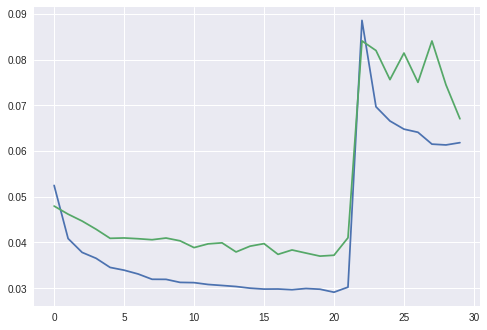

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()